# Prediction Model for NPP

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery
import pandas as pd


In [6]:
!pip install copernicusmarine
# Step 1: Install the Copernicus Marine Toolbox
import copernicusmarine

# Step 2: Login with Your Copernicus Marine Credentials
copernicusmarine.login(username="samikshakhare@gmail.com", password="Counter@1")


ERROR - 2025-05-05T20:50:55Z - Invalid credentials.
ERROR:copernicusmarine:Invalid credentials.
INFO - 2025-05-05T20:50:55Z - No configuration file have been modified.
INFO:copernicusmarine:No configuration file have been modified.
INFO - 2025-05-05T20:50:55Z - Learn how to recover your credentials at: https://help.marine.copernicus.eu/en/articles/4444552-i-forgot-my-username-or-my-password-what-should-i-do
INFO:copernicusmarine:Learn how to recover your credentials at: https://help.marine.copernicus.eu/en/articles/4444552-i-forgot-my-username-or-my-password-what-should-i-do


False

### Extract data from 2011 to 2023 from Copernicus

In [7]:
# https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_033/description

# Coordinates Near Crane Beach, small ocean patch ~6 km east of Crane Beach.
# Sargassum is a surface-floating algae, use: 05 depth

copernicusmarine.subset(
   dataset_id="cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i",
   variables = [
    "net_primary_productivity_of_biomass_expressed_as_carbon_in_sea_water",
    "euphotic_zone_depth",
    "mass_content_of_zooplankton_expressed_as_carbon_in_sea_water"
],
   start_datetime = "2011-01-01T00:00:00",
   end_datetime = "2024-12-31T23:59:59",
   minimum_longitude = -59.50,
   maximum_longitude = -59.44,
   minimum_latitude = 13.10,
   maximum_latitude = 13.12,
   minimum_depth = 0,
   maximum_depth = 5,
   output_filename = "npp_data.nc",
   output_directory = "copernicus-data"
)


INFO - 2025-05-05T20:51:03Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-05-05T20:51:03Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
WARNING - 2025-05-05T20:51:11Z - Some of your subset selection [2011-01-01 00:00:00+00:00, 2024-12-31 23:59:59+00:00] for the time dimension exceed the dataset coordinates [1998-01-01 00:00:00+00:00, 2023-12-31 00:00:00+00:00]
INFO - 2025-05-05T20:51:14Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/18 [00:00<?, ?it/s]

INFO - 2025-05-05T20:51:18Z - Successfully downloaded to copernicus-data/npp_data.nc
INFO:copernicusmarine:Successfully downloaded to copernicus-data/npp_data.nc


ResponseSubset(file_path=PosixPath('copernicus-data/npp_data.nc'), output_directory=PosixPath('copernicus-data'), filename='npp_data.nc', file_size=0.04018320610687023, data_transfer_size=89.06454961832061, variables=['npp', 'zeu', 'zooc'], coordinates_extent=[GeographicalExtent(minimum=-59.5, maximum=-59.5, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=13.083332061767578, maximum=13.083332061767578, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2011-01-01T00:00:00+00:00', maximum='2023-12-31T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

In [8]:
import xarray as xr

# Open the NetCDF file
ds = xr.open_dataset('/content/copernicus-data/npp_data.nc')


# Explore the dataset
print(ds)

<xarray.Dataset> Size: 152kB
Dimensions:    (time: 4748, latitude: 1, longitude: 1)
Coordinates:
  * latitude   (latitude) float32 4B 13.08
  * longitude  (longitude) float32 4B -59.5
  * time       (time) datetime64[ns] 38kB 2011-01-01 2011-01-02 ... 2023-12-31
Data variables:
    npp        (time, latitude, longitude) float64 38kB ...
    zeu        (time, latitude, longitude) float64 38kB ...
    zooc       (time, latitude, longitude) float64 38kB ...
Attributes:
    history:                   Created on 2024-10-17
    title:                     Global ocean low and mid trophic levels biomas...
    source:                    SEAPODYM-LMTL 3.0.0
    Conventions:               CF-1.7
    institution:               CLS
    references:                http://www.cls.fr; http://www.seapodym.eu
    copernicusmarine_version:  2.0.1


In [9]:
# Use correct variable name from dataset
npp_var = ds[['npp', 'zeu','zooc']]


# Convert to DataFrame
df = npp_var.to_dataframe().reset_index()

# Drop missing values (optional)
df = df.dropna()

# Preview the DataFrame
df.head()

,time,latitude,longitude,npp,zeu,zooc
0,2011-01-01,13.083332,-59.5,249.045828,75.501238,0.027319
1,2011-01-02,13.083332,-59.5,434.872327,59.188904,0.029596
2,2011-01-03,13.083332,-59.5,375.005543,63.451493,0.031872
3,2011-01-04,13.083332,-59.5,454.987567,57.669534,0.036425
4,2011-01-05,13.083332,-59.5,245.214354,76.160353,0.031872


In [10]:
df.shape

(4748, 6)

In [11]:
# Drop zeu and zooc columns
npp_df_cleaned = df.drop(columns=['zeu', 'zooc'])

npp_df_cleaned.head()

,time,latitude,longitude,npp
0,2011-01-01,13.083332,-59.5,249.045828
1,2011-01-02,13.083332,-59.5,434.872327
2,2011-01-03,13.083332,-59.5,375.005543
3,2011-01-04,13.083332,-59.5,454.987567
4,2011-01-05,13.083332,-59.5,245.214354


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# # Use your actual dataset: npp_df_cleaned
# # Let's follow the same steps using your real data

# # Step 1: Prepare date features if not already added
# npp_df_cleaned['time'] = pd.to_datetime(npp_df_cleaned['time'])
# npp_df_cleaned['year'] = npp_df_cleaned['time'].dt.year
# npp_df_cleaned['month'] = npp_df_cleaned['time'].dt.month
# npp_df_cleaned['dayofyear'] = npp_df_cleaned['time'].dt.dayofyear

# # Step 2: Train the model
# X = npp_df_cleaned[['year', 'month', 'dayofyear']]
# y = npp_df_cleaned['npp']
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X, y)

# # Step 3: Create future dates (2024–2030)
# future_dates = pd.date_range(start='2024-01-01', end='2030-12-31', freq='D')
# future_df = pd.DataFrame({'time': future_dates})
# future_df['year'] = future_df['time'].dt.year
# future_df['month'] = future_df['time'].dt.month
# future_df['dayofyear'] = future_df['time'].dt.dayofyear

# # Step 4: Predict NPP for future dates
# X_future = future_df[['year', 'month', 'dayofyear']]
# future_df['predicted_npp'] = model.predict(X_future)

# # Step 5: Calculate average NPP for each year
# avg_npp_historic = npp_df_cleaned.groupby('year')['npp'].mean().reset_index()
# avg_npp_future = future_df.groupby('year')['predicted_npp'].mean().reset_index()

# # Step 6: Plot historical and predicted average NPP
# plt.figure(figsize=(10, 6))
# plt.plot(avg_npp_historic['year'], avg_npp_historic['npp'], label='Avg NPP (2011–2023)', marker='o')
# plt.plot(avg_npp_future['year'], avg_npp_future['predicted_npp'], label='Predicted Avg NPP (2024–2030)', marker='o', linestyle='--')
# plt.xlabel('Year')
# plt.ylabel('Average NPP')
# plt.title('Average Annual NPP: Historical (2011–2023) vs Predicted (2024–2030)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


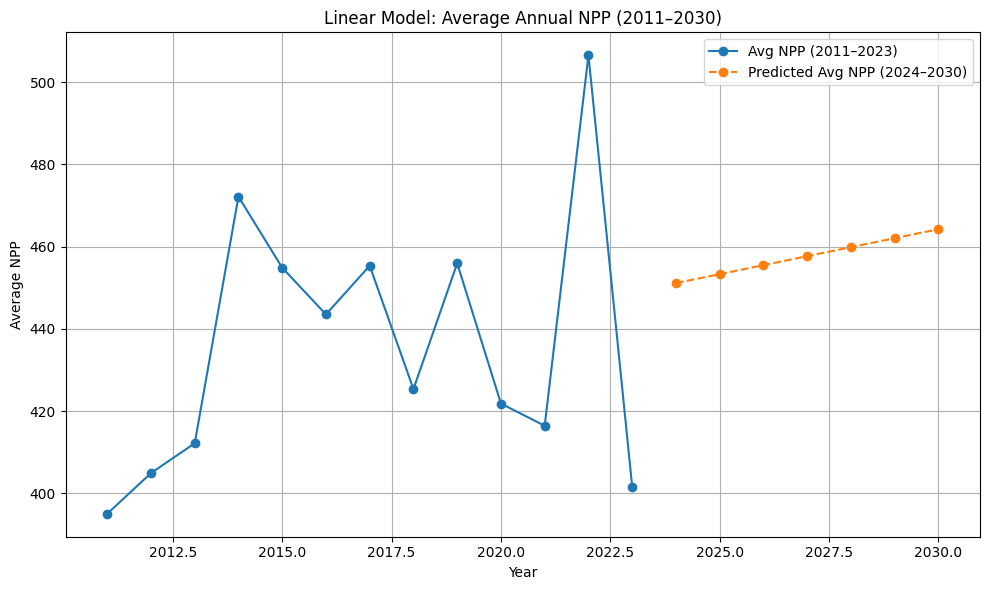

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming npp_df_cleaned is already available
npp_df_cleaned['time'] = pd.to_datetime(npp_df_cleaned['time'])
npp_df_cleaned['year'] = npp_df_cleaned['time'].dt.year

# Step 1: Average NPP per year for historical data
annual_npp = npp_df_cleaned.groupby('year')['npp'].mean().reset_index()

# Step 2: Train a model on year vs average NPP
X = annual_npp[['year']]
y = annual_npp['npp']

model = LinearRegression()
model.fit(X, y)

# Step 3: Predict future NPP from 2024 to 2030
future_years = pd.DataFrame({'year': np.arange(2024, 2031)})
future_predictions = model.predict(future_years)

# Step 4: Combine historical and predicted data
future_years['npp'] = future_predictions
combined_df = pd.concat([annual_npp, future_years])

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.plot(annual_npp['year'], annual_npp['npp'], marker='o', label='Avg NPP (2011–2023)')
plt.plot(future_years['year'], future_years['npp'], marker='o', linestyle='--', label='Predicted Avg NPP (2024–2030)')
plt.title('Linear Model: Average Annual NPP (2011–2030)')
plt.xlabel('Year')
plt.ylabel('Average NPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


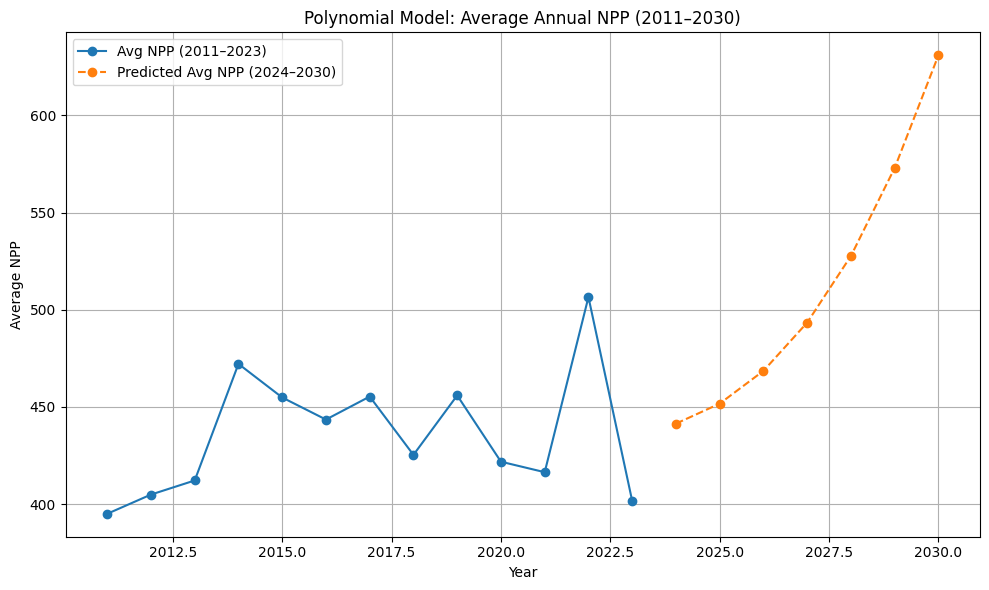

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Ensure 'time' is datetime
npp_df_cleaned['time'] = pd.to_datetime(npp_df_cleaned['time'])

# Step 1: Calculate yearly average NPP from 2011 to 2023
npp_df_cleaned['year'] = npp_df_cleaned['time'].dt.year
annual_npp = npp_df_cleaned.groupby('year')['npp'].mean().reset_index()

# Step 2: Train a Polynomial Regression Model (degree 3)
X = annual_npp[['year']]
y = annual_npp['npp']
model = make_pipeline(PolynomialFeatures(degree=44), LinearRegression())
model.fit(X, y)

# Step 3: Predict for future years 2024–2030
future_years = pd.DataFrame({'year': list(range(2024, 2031))})
future_predictions = model.predict(future_years)

# Step 4: Plot historical and predicted NPP
plt.figure(figsize=(10, 6))
plt.plot(annual_npp['year'], annual_npp['npp'], marker='o', label='Avg NPP (2011–2023)')
plt.plot(future_years['year'], future_predictions, marker='o', linestyle='--', label='Predicted Avg NPP (2024–2030)')
plt.title("Polynomial Model: Average Annual NPP (2011–2030)")
plt.xlabel("Year")
plt.ylabel("Average NPP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
